In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

Load data

In [2]:
df1 = pd.read_csv('../output/DOTA2/processed/dota2_final_09-24.csv')
df2 = pd.read_csv('../output/DOTA2/processed/dota2_final_10-24.csv')
df = pd.concat([df1, df2], axis=0)
df = df.dropna(subset=['radiant_team_id', 'dire_team_id'])

Summary statistics

In [3]:
print("# of unique matches: ", df.match_id.nunique())
print("# of unique leagues: ", df.leagueid.nunique())

unique_radiant_teams = set(df['radiant_team_id'].unique())
unique_dire_teams = set(df['dire_team_id'].unique())
total_unique_teams = len(set(unique_radiant_teams.union(unique_dire_teams)))
print("# of unique teams: ", total_unique_teams)

radiant_teams = set(df['radiant_team_id'].dropna())
dire_teams = set(df['dire_team_id'].dropna())
teams_both_radiant_and_dire = radiant_teams.intersection(dire_teams)
print("Teams that have played on both sides: ", len(teams_both_radiant_and_dire))

# of unique matches:  3274
# of unique leagues:  30
# of unique teams:  504
Teams that have played on both sides:  317


Network construction

In [4]:
G = nx.DiGraph()
for _, row in df.iterrows():
    radiant_team = row['radiant_team_id']
    dire_team = row['dire_team_id']
    if row['radiant_win']:  # Radiant team won
        if G.has_edge(radiant_team, dire_team):
            G[radiant_team][dire_team]['weight'] += 1
        else:
            G.add_edge(radiant_team, dire_team, weight=1)
    else:  # Dire team won
        if G.has_edge(dire_team, radiant_team):
            G[dire_team][radiant_team]['weight'] += 1
        else:
            G.add_edge(dire_team, radiant_team, weight=1)

In [5]:
print('# of nodes: ', G.number_of_nodes())
print('# of edges: ', G.number_of_edges())
print('Is connected: ', nx.is_weakly_connected(G))
print('# Components: ', nx.number_weakly_connected_components(G))

# of nodes:  504
# of edges:  1462
Is connected:  False
# Components:  41


In [6]:
nx.find_cycle(G)

[(8849850.0, 8849990.0), (8849990.0, 8849850.0)]

In [7]:
components = list(nx.weakly_connected_components(G))
print('Average size of component: ', sum([len(c) for c in components]) / len(components))
for component in components:
    print(component)

Average size of component:  12.292682926829269
{8850016.0, 8957156.0, 8849990.0, 8849833.0, 8970060.0, 8849837.0, 8987220.0, 8850100.0, 8849817.0, 8849850.0}
{9466541.0, 9466544.0, 9466547.0, 9466548.0, 9466549.0, 9466551.0, 9466552.0, 9466553.0}
{8629315.0, 9426115.0, 8629317.0, 8629318.0, 8629324.0, 8629005.0, 2443375.0, 8629014.0, 9425656.0, 9425660.0}
{9545732.0, 5.0, 8756744.0, 9254408.0, 9545744.0, 7119388.0, 9545759.0, 36.0, 9512487.0, 39.0, 9499177.0, 9338413.0, 9518126.0, 9500213.0, 9545782.0, 8291895.0, 9098294.0, 9247798.0, 9373238.0, 9351740.0, 8599101.0, 9538624.0, 9315393.0, 9545792.0, 9530947.0, 8736331.0, 9324110.0, 9080405.0, 9373270.0, 9450071.0, 9103961.0, 9554522.0, 9303643.0, 8944221.0, 8574561.0, 9546337.0, 8944230.0, 9537639.0, 7059562.0, 9175147.0, 9539693.0, 9546351.0, 2163.0, 9247354.0, 9409659.0, 9257597.0, 9546878.0, 9255039.0, 7554697.0, 9449099.0, 9519244.0, 9175186.0, 8771219.0, 9476766.0, 9538207.0, 9438887.0, 8605863.0, 8588969.0, 8838314.0, 9472684.0, 

Count Playing Teams Per Day

In [8]:
df['start_date_time'] = pd.to_datetime(df['start_date_time'])
df['week'] = df['start_date_time'].dt.isocalendar().week
madrid_blue = "#3333b2"

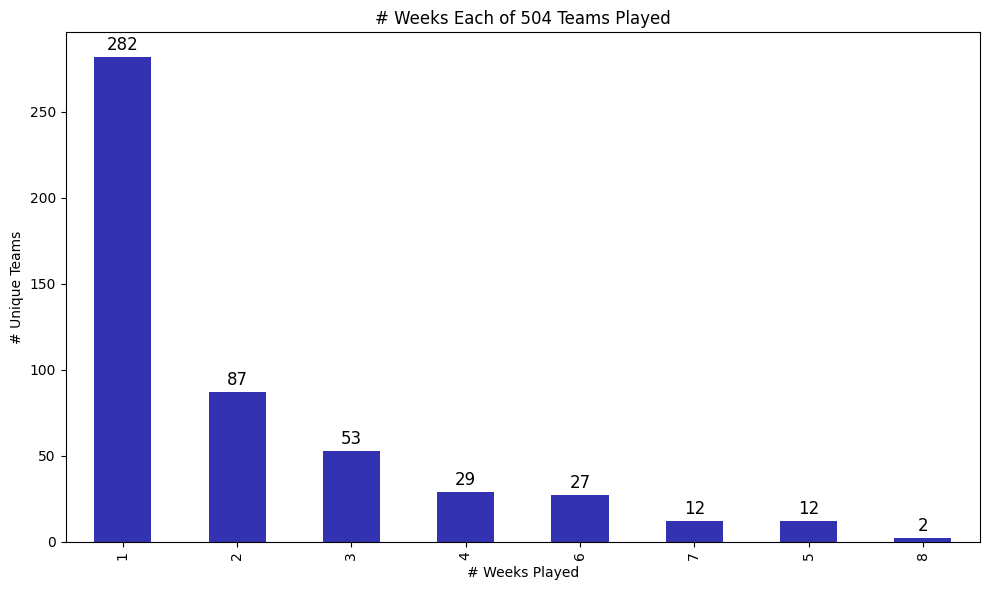

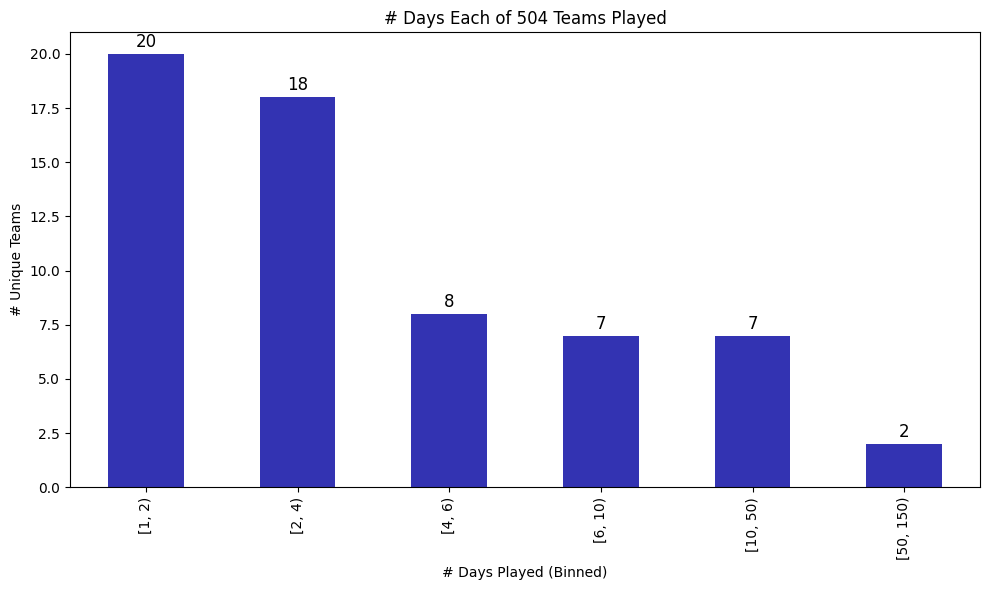

In [9]:
def team_weeks_played(df):
    df['teams'] = df[['radiant_team_id', 'dire_team_id']].apply(lambda x: list(x), axis=1)
    df_teams = df.explode('teams')
    team_weeks_played = df_teams.groupby('teams')['week'].nunique()
    return team_weeks_played

def team_days_played(df):
    df['teams'] = df[['radiant_team_id', 'dire_team_id']].apply(lambda x: list(x), axis=1)
    df_teams = df.explode('teams')
    team_days_played = df_teams.groupby('teams').size()
    return team_days_played

team_weeks_data = team_weeks_played(df).sort_values(ascending=False).value_counts()
team_days_data = team_days_played(df).sort_values(ascending=False).value_counts()

bins = [1, 2, 4, 6, 10, 50,  150]  # You can adjust the bin ranges as needed
team_days_binned = pd.cut(team_days_data, bins=bins, right=False)
team_days_binned_counts = team_days_binned.value_counts(sort=False)

def plot_with_annotations(data, title, xlabel, ylabel):
    ax = data.plot(kind='bar', figsize=(10, 6), color=madrid_blue)
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

plot_with_annotations(team_weeks_data, '# Weeks Each of 504 Teams Played', '# Weeks Played', '# Unique Teams')
plot_with_annotations(team_days_binned_counts, '# Days Each of 504 Teams Played', '# Days Played (Binned)', '# Unique Teams')

In [10]:
df['start_date_time'] = pd.to_datetime(df['start_date_time'], errors='coerce')

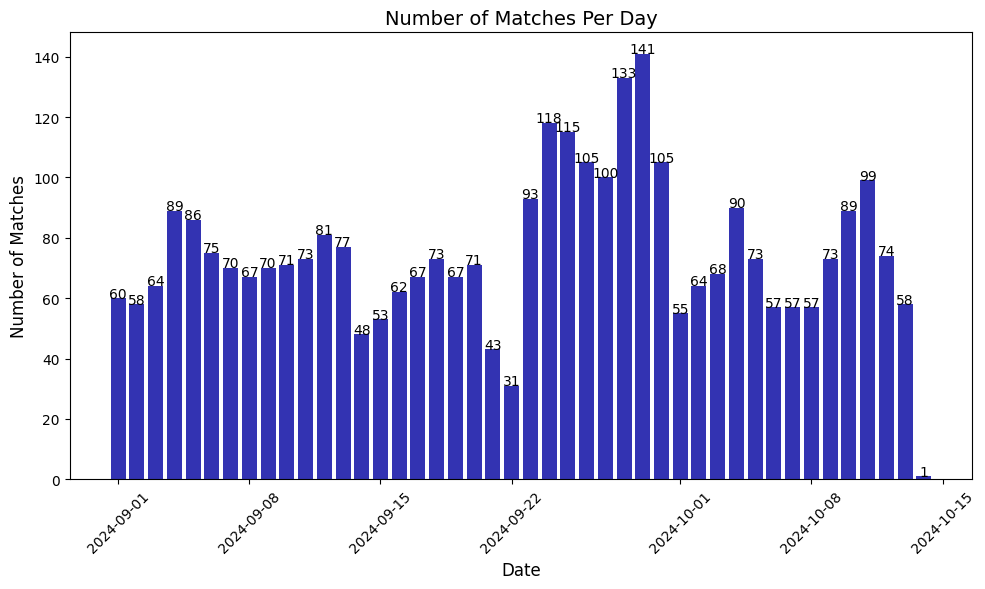

In [11]:
# Set the start_date_time column as the index
df.set_index('start_date_time', inplace=True)

# Group data by date and count the number of matches per day
matches_per_day = df.resample('D').size().reset_index(name='num_matches')

# Plot the number of matches per day as a bar chart
plt.figure(figsize=(10, 6))
plt.bar(matches_per_day['start_date_time'], matches_per_day['num_matches'], color=madrid_blue)

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Matches', fontsize=12)
plt.title('Number of Matches Per Day', fontsize=14)
plt.xticks(rotation=45)
plt.grid(False)

# Annotate each bar with the number of matches
for i in range(len(matches_per_day)):
    plt.text(matches_per_day['start_date_time'][i], 
             matches_per_day['num_matches'][i] + 0.2, 
             str(matches_per_day['num_matches'][i]), 
             ha='center', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
# count num matches per league
num_matches_per_league = df['leagueid'].value_counts().reset_index()
num_matches_per_league.columns = ['leagueid', 'num_matches']
num_matches_per_league.sort_values('num_matches', ascending=False)

,leagueid,num_matches
0,16059,557
1,15901,547
2,16635,372
3,17135,272
4,16312,228
5,17233,195
6,16935,121
7,17119,119
8,16251,102
9,17021,89


In [13]:
# Group the data by team ID (both radiant and dire) and count the unique leagues each team has participated in.

# For Radiant teams
radiant_league_counts = df.groupby('radiant_team_id')['leagueid'].nunique()

# For Dire teams
dire_league_counts = df.groupby('dire_team_id')['leagueid'].nunique()

# Combine both into one DataFrame
team_league_counts = pd.DataFrame({
    'radiant_team_leagues': radiant_league_counts,
    'dire_team_leagues': dire_league_counts
}).fillna(0)  # Fill NaN values with 0 for teams that don't appear in either radiant or dire roles.

# Add a total league participation column (summing radiant and dire)
team_league_counts['total_leagues'] = team_league_counts['radiant_team_leagues'] + team_league_counts['dire_team_leagues']

In [14]:
team_league_counts.sort_values('total_leagues', ascending=False)

,radiant_team_leagues,dire_team_leagues,total_leagues
9403748.0,5.0,5.0,10.0
9247798.0,4.0,4.0,8.0
8728920.0,4.0,4.0,8.0
8254400.0,4.0,4.0,8.0
9498970.0,4.0,4.0,8.0
...,...,...,...
9032849.0,0.0,1.0,1.0
9025359.0,1.0,0.0,1.0
9505130.0,0.0,1.0,1.0
9505163.0,0.0,1.0,1.0


In [15]:
# Concatenate both radiant and dire teams
combined_data = pd.concat([
    df[['radiant_team_id', 'leagueid']].rename(columns={'radiant_team_id': 'team_id'}),
    df[['dire_team_id', 'leagueid']].rename(columns={'dire_team_id': 'team_id'})
])

# Group by team ID and count the number of unique leagues
team_league_count = combined_data.groupby('team_id')['leagueid'].nunique()

# Display the result
team_league_count_df = pd.DataFrame(team_league_count).rename(columns={'leagueid': 'num_leagues'}).reset_index()
team_league_count_df.sort_values('num_leagues', ascending=False)

,team_id,num_leagues
227,9403748.0,5
336,9498970.0,4
156,9247798.0,4
257,9449748.0,4
46,8254400.0,4
...,...,...
194,9339581.0,1
193,9338991.0,1
192,9338738.0,1
186,9330961.0,1


In [16]:
team_league_count_df.num_leagues.value_counts()

num_leagues
1    417
2     59
3     19
4      8
5      1
Name: count, dtype: int64

Network visualization

In [17]:
#pos = nx.spring_layout(G, k=0.1)
pos = nx.kamada_kawai_layout(G)

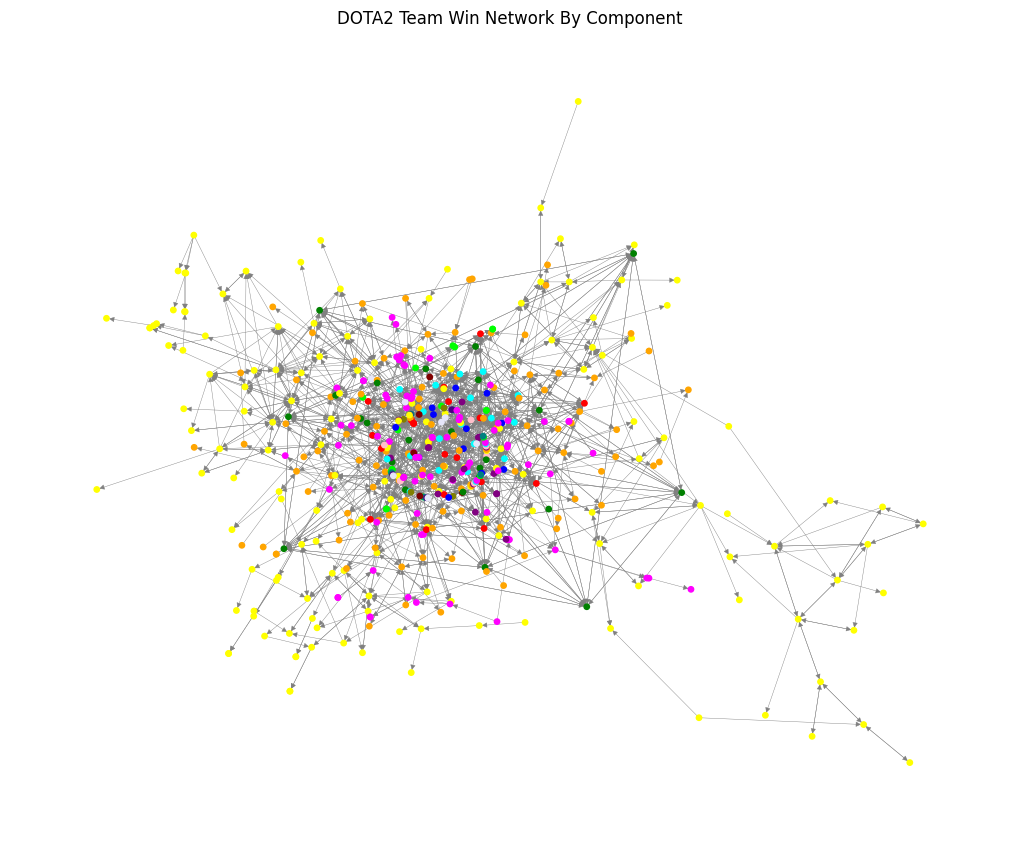

In [18]:
colors = ["Red", "Blue", "Green", "Yellow", "Orange", "Purple", "Pink", "Cyan", 
        "Magenta", "Lime", "Teal", "Indigo", "Lavender", "Olive", "Maroon"]

node_colors = {}
for i, component in enumerate(components):
    for node in component:
        node_colors[node] = colors[i % len(colors)]  

node_color_list = [node_colors[node] for node in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw(G, pos, node_color=node_color_list, 
        edge_color='gray', 
        font_weight='bold',# edgecolors='black',
        font_size=10, arrowsize=8, node_size=15, width=0.3)

plt.title("DOTA2 Team Win Network By Component")
plt.show()